In [ ]:
!wget https://bc-cv.github.io/csci3397/public/dip_registration/exemplar-001-cycle-01.ome.tiff
!wget https://bc-cv.github.io/csci3397/public/dip_preprocess/folker_muscle.czi

## Background

All image data can be represented by 2D matrix of pixels, with the position of the pixels represented as x and y coordinated and the values of these pixels ranging from 0(black) to 255(white). Alot of following images stolen from https://www.whydomath.org/node/wavlets/imagebasics.html

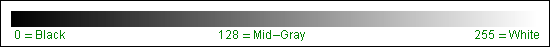

These pixel values are then colorized by incorporating a third dimension to the matrix that has a size of 3. Each layer represents a red, blue, and green channel with the same dimensions of the image.

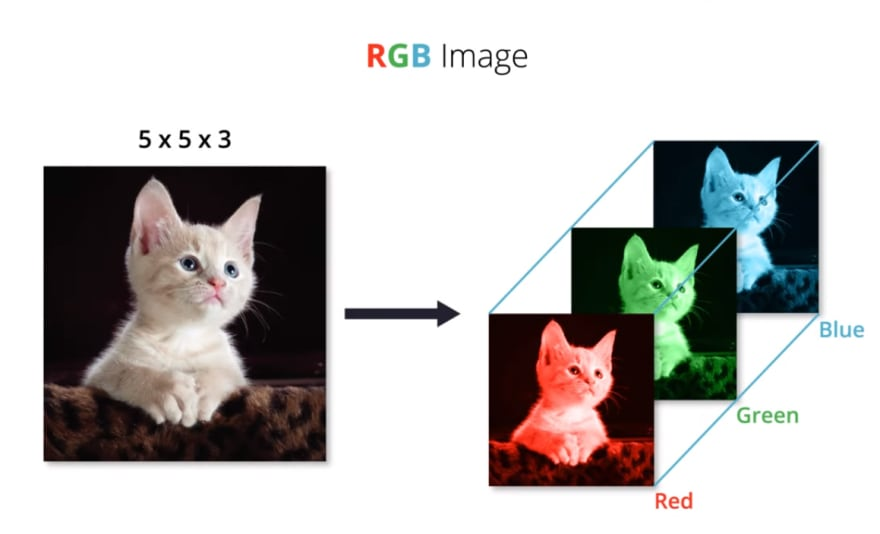

However, in specific subjects like microscopy, these images can have more 3 dimensions! The extra dimensions can represent specific characteristics about the image such as focal planes or time taken

# Analyzing Microscopy Images of Muscle Fibers

Here we have an image of a multi-nucleated cell with microtubules stretching around it. The purpose of this lesson is to show how we can use different image analysis techniques to segment out either the nuclei or microtubules based on their characteristics

In [3]:
%pip install czifile
import czifile

Defaulting to user installation because normal site-packages is not writeable
  Using cached czifile-2019.7.2-py2.py3-none-any.whl (18 kB)
     |████████████████████████████████| 10.9 MB 4.5 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 220 kB 14.9 MB/s eta 0:00:01

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
img = czifile.imread('folker_muscle.czi')
print('original image shape is: ',img.shape)
img = np.squeeze(img)
print('squeezed image shape is:', img.shape)
focal_img = img[:,5,:,:] #12 represents focal planes
print('one focal plane shape is: ',focal_img.shape)
new_img = np.zeros((focal_img.shape[1],focal_img.shape[2],3),np.uint8)
print('our new image shape is: ', new_img.shape)
new_img[:,:,0] = focal_img[1] #flip because red and green were backwards
new_img[:,:,1] = focal_img[0]
plt.imshow(new_img)

### Image Enhancement


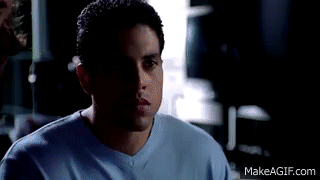

Enhancing an image is a myth. You can not make up information about parts of an image. Instead, you can scale properties about the current image information to increase contrast to help visualize aspects about that image!

Here, we are removing the outlier pixel values (1% and 99%, or whatever you want it to be) for each channel and then scale each channel's range to 0-255!

In [ ]:
def imAdjust2(I, thres=[1,99]):
    # compute percentile: remove too big or too small values
    I_low, I_high = np.percentile(I.reshape(-1), thres)
    print(I_low,I_high)
    # thresholding
    I[I > I_high] = I_high
    I[I < I_low] = I_low
    # scale to 0-1
    #print(I[400,400])
    I = (I.astype(float)- I_low)/ (I_high-I_low)
    #print(I[400,400])
    # convert it to uint8
    I = (I * 255).astype(np.uint8)
    return I

new_img = imAdjust2(new_img)
plt.imshow(new_img, cmap='jet')
plt.axis('off')

### Nucleus Analysis

What if wanted to just get the part of the image that include the nuclei? One way to do this is to apply a filter to remove noise from the nuclei to maintain its shape

Here we are going to include a median blur, Which takes the median of all the area under a set kernel (area surrounding the center) and replaces that center marker with the median.

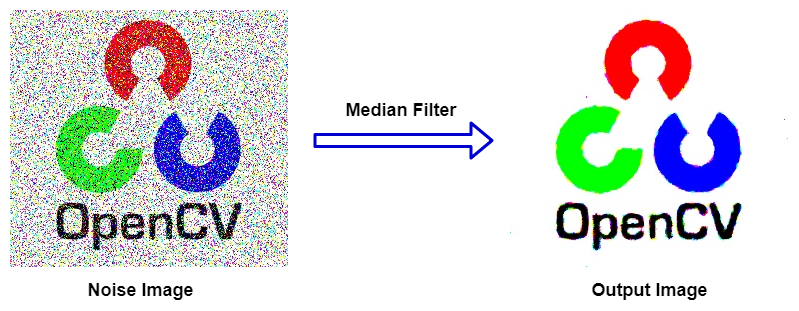

In [ ]:
import cv2
kernel = 55 #can edit this

img_cv2 = cv2.medianBlur(new_img[:,:,0],kernel)

plt.figure(figsize=(8, 8))
plt.imshow(img_cv2)
plt.axis('off')

The next part is applying a binary mask to only keep parts of the image that are apart of the bedian blur

In [ ]:
threshold = 6
bin_image = img_cv2>threshold
plt.imshow(bin_image,cmap='gray')
plt.axis('off')

# Pathology Image Registration and Segmentation

We are switching gears now to show how Python and image analysis tools can be used to analyze immunofuorescence images for pathology

In [ ]:
! pip install aicsimageio

In [ ]:
from aicsimageio.readers.ome_tiff_reader import OmeTiffReader
import matplotlib.pyplot as plt

im = OmeTiffReader('exemplar-001-cycle-01.ome.tiff')

num_scenes = len(im.scenes)
num_disp_col = 2
num_disp_row = (num_scenes + num_disp_col - 1) // num_disp_col

plt.figure(figsize=(8,8))
for scene_id in range(num_scenes):
    im.set_scene(scene_id)
    tile = im.get_image_data()
    plt.subplot(num_disp_row, num_disp_col, scene_id+1)
    plt.imshow(tile[0,0,0], cmap='gray')
plt.show()

In [ ]:
im.set_scene(0)
tile = imAdjust2(im.get_image_data())
tile0 = tile[0,0,0,:256,-256:]
im.set_scene(1)
tile = imAdjust2(im.get_image_data())
tile1 = tile[0,0,0,:256,:256]

plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(tile0,cmap='gray')
plt.subplot(122)
plt.imshow(tile1,cmap='gray')

### Image Stitching [[link]](https://en.wikipedia.org/wiki/Image_stitching)

In [ ]:
out_img = np.zeros([tile0.shape[0],tile0.shape[1]*2])
out_img[:tile0.shape[0],:tile0.shape[1]] = tile0
out_img[:tile0.shape[0],tile0.shape[1]:] = tile1
plt.figure(figsize=(8,8))
plt.imshow(out_img)
out_img.shape

You can clearly see the overlap of the two images where the data is the same. Is there an automated way of detecting this overlap and removing it to make a clear image stitching?

Let's start by visualizing the over lap by specific color channel

In [ ]:
tile0_crop = out_img[:,180:256]
tile1_crop = out_img[:,256:332]
out_b = np.zeros([tile0_crop.shape[0], tile0_crop.shape[1], 3], np.uint8)
out_b[:,:,0] = tile0_crop
out_b[:,:,1] = tile1_crop
print(out_b.shape)
plt.figure(figsize=(8, 8))
plt.imshow(out_b);
plt.axis('off')
plt.show()

We can utilize functions from within the `cv2` package, to draw connections between the two channels for the computer to detect where the overlap is!

In [ ]:
import cv2

#Renormalize Data, should already be done
tile0_crop2 = cv2.normalize(tile0_crop, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
tile1_crop2 = cv2.normalize(tile1_crop, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

#Scale-Invariant Feature Transformation. Used to detect features across
sift = cv2.SIFT_create()
kp_0, desc_0 = sift.detectAndCompute(tile0_crop2,None)
kp_1, desc_1 = sift.detectAndCompute(tile1_crop2,None)

kp_img1 = cv2.drawKeypoints(tile0_crop2, kp_0, None, color=(0,255,0), flags=0)
kp_img2 = cv2.drawKeypoints(tile1_crop2, kp_1, None, color=(0,255,0), flags=0)

#plotImgPair(kp_img1, kp_img2)

bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)
matches = bf.match(desc_0,desc_1)
matches = sorted(matches, key = lambda x:x.distance)
match_plot = cv2.drawMatches(tile0_crop2, kp_0, tile1_crop2, kp_1, matches[:20], None, flags=2)

plt.figure(figsize=(16, 8))
plt.imshow(match_plot)

pts_0 = np.vstack([kp_0[m.queryIdx].pt for m in matches])
pts_1 = np.vstack([kp_1[m.trainIdx].pt for m in matches])

T_aff, status = cv2.estimateAffine2D(pts_1, pts_0, cv2.RANSAC)
print(T_aff)

We can now create a "warped" image that incorporates these shared connections and visualize it by plotting the warped image on a different color channel than the original image

In [ ]:
im2_affine = cv2.warpAffine(tile1_crop,T_aff,tile0_crop.transpose().shape)
print(im2_affine.shape)
print(tile0_crop.shape)
out_2 = np.zeros([tile0_crop.shape[0], tile0_crop.shape[1], 3], np.uint8)
out_2[:,:,0] = tile0_crop
out_2[:,:,1] = im2_affine

plt.figure(figsize=(8, 8))
plt.imshow(out_2);plt.axis('off')

Let's now put the warped image dimensions within our original picture to produce the seamless stitching of the two pathology stains!

In [ ]:
big_img = np.zeros([tile0.shape[0],tile0.shape[1]*2-76]) #76 is amount of overlap from cropped images
tile1_affine = cv2.warpAffine(tile1,T_aff,tile0.shape)
big_img[:,180:] = tile1_affine
big_img[:,:256] = tile0
print(big_img.shape)
plt.figure(figsize=(8,8))
plt.imshow(big_img)

### Image Segmentation

What if we now want to detect each one of our cells in this immunoflourescence stain? We can use segmentation tools to better visualize different aspects of the cell [[link]](https://en.wikipedia.org/wiki/Image_segmentation)

The first step is to apply a blur filter, here we are using a Gaussian blur, to get a better understanding of each shape of the cell and then use a binarization mask to show where each cell is.

In [ ]:
from scipy import ndimage as ndi
from skimage.color import label2rgb
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import measure

big_img2 = cv2.normalize(big_img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
big_img_blur = cv2.GaussianBlur(big_img2,(5,5),0)
_, big_img_blur_otsu = cv2.threshold(big_img_blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(big_img_blur_otsu)

We are going to be using a [watershed segmentation](https://docs.opencv.org/3.4/d3/db4/tutorial_py_watershed.html) to detail each cell. This algorithm treats an image as a topological map and fill the valleys (aka light spots, aka cells ) with different colors until they reach and merge with a different color. The image below shows the start of each valley using a distance command

In [ ]:
big_distance = ndi.distance_transform_edt(big_img_blur_otsu)

optima_window_size = 21
coords = peak_local_max(big_distance,footprint=np.ones((optima_window_size, optima_window_size)),labels=big_img_blur_otsu)
big_mask = np.zeros(big_distance.shape, dtype=bool)
big_mask[tuple(coords.T)] = True
big_markers, _ = ndi.label(big_mask)
plt.imshow(big_mask)

Now lets fill up each of the cells until the merge with other cells

In [ ]:
big_seg_watershed = watershed(-big_distance, big_markers, mask=big_img_blur_otsu)


plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(big_img2,cmap='gray')
plt.subplot(122)
plt.imshow(label2rgb(big_seg_watershed, bg_label=0),cmap='gray')

We can now save the properties of each cell (area id) into a `.csv` file for future analysis!

In [ ]:
import pandas as pd

big_img_table = measure.regionprops_table(big_seg_watershed,properties=('area','perimeter'))
big_img_areas = big_img_table['area']
table = np.zeros([big_seg_watershed.max(),2])
table[:,0] = range(1,big_seg_watershed.max()+1)
table[:,1] = big_img_areas
#np.savetxt('cell_stats.csv',table,header='Cell id, area',delimiter=',')
pd.DataFrame(table,columns=('Cell ID','Area'))